# Lending Scoring based on xgboost

In [1]:
%matplotlib inline
import sys, os
import numpy as np
import xgboost as xgb
import seaborn as sns
import pandas as pd
#from sklearn.model_selection import train_test_split
from sklearn.datasets import make_classification
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.cross_validation import train_test_split


sns.set(font_scale = 1.5)

/Users/andrescala/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
data = pd.read_csv('data/cs-training.csv').drop('id', axis = 1)
dataPredict = pd.read_csv('data/cs-test.csv').drop('id', axis = 1)

#print(dataTest.shape)

dataTrain, dataTest = train_test_split(data, test_size=0.30)
print(dataTrain.shape)
print(dataTest.shape)
print(dataPredict.shape)


(105000, 11)
(45000, 11)
(101503, 11)


In [3]:
target = dataTrain['SeriousDlqin2yrs']
targetT = dataTest['SeriousDlqin2yrs']
#print(target.shape)
dataTrain = dataTrain.drop(['SeriousDlqin2yrs'],axis=1)
dataTest = dataTest.drop(['SeriousDlqin2yrs'],axis=1)
dataPredict = dataPredict.drop(['SeriousDlqin2yrs'],axis=1)

print(dataTrain.shape)
print(dataTest.shape)
print(dataPredict.shape)
featNames = ['RevolvingUtilizationOfUnsecuredLines',
 'age',
 'NumberOfTime30-59DaysPastDueNotWorse',
 'DebtRatio',
 'MonthlyIncome',
 'NumberOfOpenCreditLinesAndLoans',
 'NumberOfTimes90DaysLate',
 'NumberRealEstateLoansOrLines',
 'NumberOfTime60-89DaysPastDueNotWorse',
 'NumberOfDependents']
xgtrain = xgb.DMatrix(dataTrain.values, label=target, feature_names=featNames )
xgtest = xgb.DMatrix(dataTest.values, label=targetT, feature_names=featNames)
xgpredict = xgb.DMatrix(dataPredict, label=None, feature_names=featNames)

(105000, 10)
(45000, 10)
(101503, 10)


In [4]:
params = {
    'objective':'binary:logistic',
    'max_depth':3,
    'silent':1,
    'eta':0.4
}
params['eval_metric'] = ['error', 'auc']

num_rounds = 50

In [5]:
watchlist  = [(xgtest,'test'), (xgtrain,'train')] # native interface only
bst = xgb.train(params, xgtrain, num_rounds, watchlist, early_stopping_rounds=5)
print("Best train score: {}".format(bst.best_score))
print("Best iteration: {}".format(bst.best_iteration))
print("Best number of trees limit: {}".format(bst.best_ntree_limit))


[0]	test-error:0.0628	test-auc:0.820171	train-error:0.064962	train-auc:0.811279
Multiple eval metrics have been passed: 'train-auc' will be used for early stopping.

Will train until train-auc hasn't improved in 5 rounds.
[1]	test-error:0.062444	test-auc:0.831499	train-error:0.064314	train-auc:0.822121
[2]	test-error:0.062444	test-auc:0.842962	train-error:0.064343	train-auc:0.8339
[3]	test-error:0.062133	test-auc:0.84863	train-error:0.063895	train-auc:0.840267
[4]	test-error:0.0616	test-auc:0.848985	train-error:0.063933	train-auc:0.840893
[5]	test-error:0.061644	test-auc:0.850989	train-error:0.064029	train-auc:0.842826
[6]	test-error:0.061578	test-auc:0.853625	train-error:0.063667	train-auc:0.846211
[7]	test-error:0.061822	test-auc:0.856527	train-error:0.063752	train-auc:0.850411
[8]	test-error:0.061644	test-auc:0.856983	train-error:0.063571	train-auc:0.85089
[9]	test-error:0.061578	test-auc:0.860585	train-error:0.06341	train-auc:0.853854
[10]	test-error:0.061556	test-auc:0.863456	trai

In [6]:
bst.save_model('gen_data/featMap.txt')
trees_dump = bst.get_dump(fmap='gen_data/featMap.txt', with_stats=True)

for tree in trees_dump:
    print(tree)

0:[f6<0.5] yes=1,no=2,missing=1,gain=2984.22,cover=26250
	1:[f0<0.549656] yes=3,no=4,missing=3,gain=662.176,cover=24796
		3:[f2<0.5] yes=7,no=8,missing=7,gain=136.027,cover=19191.2
			7:leaf=-0.771963,cover=17190.2
			8:leaf=-0.66034,cover=2001
		4:[f8<0.5] yes=9,no=10,missing=9,gain=361.089,cover=5604.75
			9:leaf=-0.633438,cover=5162.25
			10:leaf=-0.256144,cover=442.5
	2:[f6<1.5] yes=5,no=6,missing=5,gain=217.524,cover=1454
		5:[f0<0.495489] yes=11,no=12,missing=11,gain=116.204,cover=915.25
			11:leaf=-0.457903,cover=299.5
			12:leaf=-0.154033,cover=615.75
		6:[f2<0.5] yes=13,no=14,missing=13,gain=35.9707,cover=538.75
			13:leaf=-0.0599769,cover=215.75
			14:leaf=0.150617,cover=323

0:[f6<0.5] yes=1,no=2,missing=1,gain=1527.92,cover=23207.1
	1:[f2<1.5] yes=3,no=4,missing=3,gain=532.913,cover=21774
		3:[f0<0.501214] yes=7,no=8,missing=7,gain=277.426,cover=20877.8
			7:leaf=-0.548704,cover=15820.2
			8:leaf=-0.440762,cover=5057.59
		4:[f0<0.705326] yes=9,no=10,missing=9,gain=98.0917,c

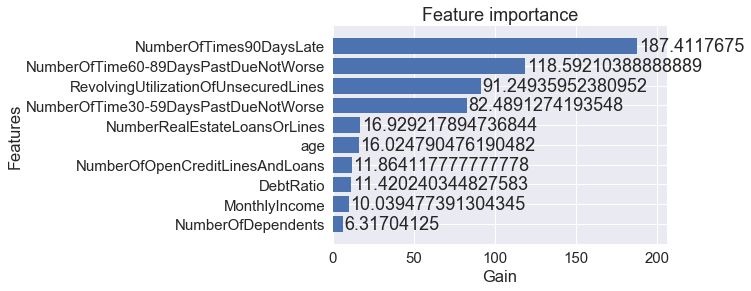

In [14]:
xgb.plot_importance(bst, importance_type='gain', xlabel='Gain', height=0.8)

In [8]:
seed = 10000
num_rounds = 10
params1 = {
    'objective':'binary:logistic',
    'max_depth':5,
    'silent':1,
    'eta':0.4
}
hist = xgb.cv(params1, xgtrain, num_rounds, nfold=10, metrics={'auc'}, seed=seed)
hist

,test-auc-mean,test-auc-std,train-auc-mean,train-auc-std
0,0.839611,0.007679,0.842476,0.001490
1,0.844545,0.007589,0.848306,0.001577
2,0.846649,0.007908,0.850265,0.001294
3,0.848119,0.008076,0.851822,0.000891
4,0.849844,0.007495,0.853628,0.000985
5,0.851331,0.007591,0.856232,0.001091
6,0.853645,0.007644,0.859370,0.000971
7,0.854815,0.007525,0.862319,0.000728
8,0.855826,0.007139,0.864484,0.000761
9,0.856981,0.006979,0.866361,0.000802


In [9]:
y_test_preds = (bst.predict(xgtest)).astype('int')
print(sum(y_test_preds))
print(len(targetT))

0
45000


In [12]:
#xgtrain.feature_names xgtrain xgtest
#xgpredict.feature_names
y_test_preds = (bst.predict(xgtest) > 0.5).astype('int')
pd.crosstab(
    pd.Series(targetT, name='Actual'),
    pd.Series(y_test_preds, name='Predicted'),
    margins=True
)

Predicted,0.0,1.0,All
Actual,,,
0.0,12547,291,12838
1.0,882,10,892
All,13429,301,13730


In [13]:
print('Accuracy: {0:.2f}'.format(accuracy_score(targetT, y_test_preds)))
print('Precision: {0:.2f}'.format(precision_score(targetT, y_test_preds)))
print('Recall: {0:.2f}'.format(recall_score(targetT, y_test_preds)))

Accuracy: 0.94
Precision: 0.62
Recall: 0.21
